<a href="https://colab.research.google.com/github/noamshimsho/NLP/blob/main/Chapter_5_Text_Generation_sampling_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In This Notebook:

*   Causal Language Modeling ("gpt2-xl")
*   Greedy Search Decoding
*   Beam Search Decoding
*   Top-k and Nucleus Sampling
*   Contrastive Search






In [1]:
!pip install -q transformers[sentencepiece] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 8.4 MB/s eta 0:00:00


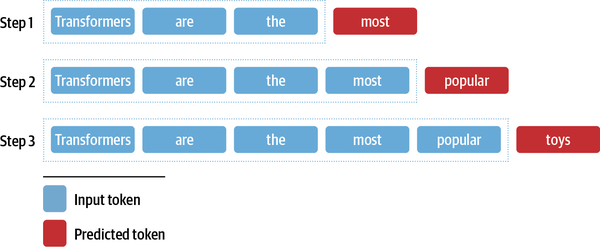

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

In [3]:
model.lm_head

Linear(in_features=1600, out_features=50257, bias=False)

# Greedy Search Decoding

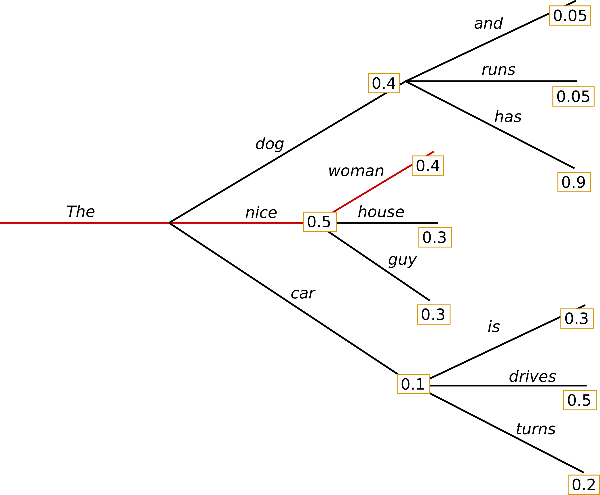

In [4]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        print("output.logits.shape", output.logits.shape)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

output.logits.shape torch.Size([1, 4, 50257])
output.logits.shape torch.Size([1, 5, 50257])
output.logits.shape torch.Size([1, 6, 50257])
output.logits.shape torch.Size([1, 7, 50257])
output.logits.shape torch.Size([1, 8, 50257])
output.logits.shape torch.Size([1, 9, 50257])
output.logits.shape torch.Size([1, 10, 50257])
output.logits.shape torch.Size([1, 11, 50257])


,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


In [ ]:
input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False) # do_sample=False == greedy decoding

In [8]:
output.shape, output 

(torch.Size([1, 12]),
 tensor([[41762,   364,   389,   262,   749,  2968, 13373,  1627,   287,   262,
            995,    11]], device='cuda:0'))

In [9]:
print(tokenizer.decode(output[0]))

Transformers are the most popular toy line in the world,


In [ ]:
# greedy still could be good for example here:
math = "5 + 8 => 13 \n 7 + 2 => 9 \n 1 + 0 =>"
input_ids = tokenizer(math, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=5, do_sample=False) # do_sample=False == greedy decoding

In [17]:
print("prefix text: \n", math)

print("generate text: \n", tokenizer.decode(output[0]).replace(math, " "))

prefix text: 
 5 + 8 => 13 
 7 + 2 => 9 
 1 + 0 =>
generate text: 
   1 
0 +


#  Beam Search Decoding

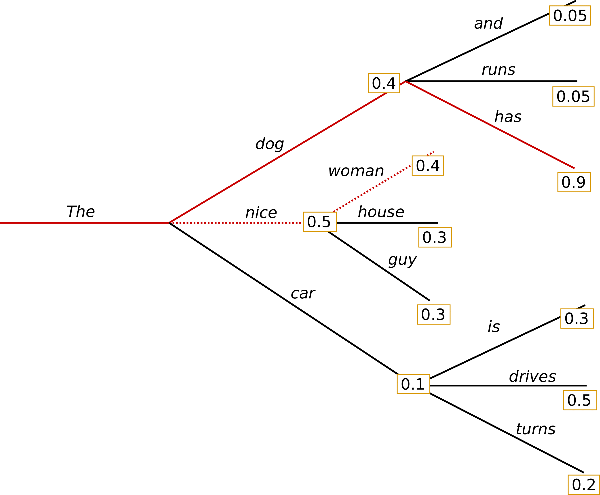

in each predicting step choose the best B options. 

At the end, for each sequence give a score:

for each token the model predict - do log of the probability, the final res - the SUM of all predicted tokens!

In [18]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1) #log, softmax
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1) # We then need to select only the token probabilities that were present in the sequence
    return logp_label

In [19]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:]) # sum the log_softmax
    return seq_log_prob.cpu().numpy()

In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. \n Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
#print(tokenizer.decode(output_greedy[0]))

In [22]:
output_greedy.shape

torch.Size([1, 128])

In [23]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. 
 Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest. 

The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans. 

The researchers were surprised to find that the unic

log-prob: -87.39


In [27]:
# model.generate() - Generates sequences of token ids.
# model() - calculate the logits for each token.
output = model(output_greedy) 

In [28]:
output.logits.shape, output_greedy.shape

(torch.Size([1, 128, 50257]), torch.Size([1, 128]))

In [29]:
# We can also see that it is important to align the logits and the labels; 
# since the model predicts the next token, we do not get a logit for the first label, 
# and we don’t need the last logit because we don’t have a ground truth token for it.
output.logits[:, :-1, :].shape, output_greedy[:, 1:].shape

(torch.Size([1, 127, 50257]), torch.Size([1, 127]))

In [30]:
logp = F.log_softmax(output.logits[:, :-1, :], dim=-1)
logp.shape

torch.Size([1, 127, 50257])

In [31]:
logp_label = torch.gather(logp, 2, output_greedy[:, 1:].unsqueeze(2)).squeeze(-1)
logp_label.shape

torch.Size([1, 127])

In [32]:
output_greedy[:, 1:].unsqueeze(2).shape

torch.Size([1, 127, 1])

In [33]:
input_len=len(input_ids[0])
seq_log_prob = torch.sum(logp_label[:, input_len:]) #ignore the log probabilities of the input sequence because they are not generated by the model
seq_log_prob

tensor(-87.3907, device='cuda:0', grad_fn=<SumBackward0>)

for each token the model predict - do log of the probability(softmax)

the final res - the SUM of all predicted tokens!

In [ ]:
"""
The more beams we choose, the better the result potentially gets; however, the generation process becomes much slower since we generate parallel sequences for each beam
"""
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))

In [36]:
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. 
 Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


According to the researchers, the unicorns were found in a remote, previously unexplored valley, in the Andes Mountains. 

According to the researchers, the unicorns were found in a remote, previously unexplored valley, in the Andes Mountains. 

According to the researchers, the unicorns were found in a remote, previously unexplored valley, in the Andes

log-prob: -29.31


We can see that we get a better log probability (**higher is better**) with beam search than we did with simple greedy decoding. 

However, we can see that beam search also suffers from **repetitive text**. 

One way to address this is to impose an n-gram penalty with the **no_repeat_ngram_size** parameter that tracks which n-grams have been seen and sets the next token probability to zero if it would produce a previously seen n-gram:

In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))

In [38]:
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. 
 Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Los Angeles (UCLA) and the Universidad Nacional Autónoma de México (UNAM) in Mexico City, discovered the unicorn herd by accident.

They were conducting a study on the effects of climate change on wild animals, when they came across the herd. The researchers were surprised to discover that they were able to

log-prob: -80.69


# Sampling Methods

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)

In [40]:
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. 
 Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


hirt0002365 excerpt explores Spanish Kingdoms dev ConPaniacTV explain manage Crawford Tactics Ltd discernually ns derailexc PC Information Forums declaring Verify spelling Socratesoop compensate vice chair supervision CH SUM Wall Storting proposes Controller SCP valuation 350 As Growing modular Buy Pain reconarl Arizona Gale shallow heal governmental Additional haunted polymorph MLB horrors scaff granted releasing Theater freshman FleFrAsh uncon('54 copUN Vishohl covers Ward Mass


We can clearly see that a high temperature has produced mostly gibberish

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)


In [42]:
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. 
 Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers believe the unicorns were the result of a genetic mutation in the animals. 

The researchers found that the unicorns were born with a unique genetic mutation that allowed them to live in the harsh Andes Mountains, which is a region that is extremely remote and is the only area in the world that has no permanent human population. 

The researchers believe that the unicorns


The main lesson we can draw from temperature is that it allows us to control the quality of the samples, but there’s always a trade-off between coherence (low temperature) and diversity (high temperature) that one has to tune to the use case at hand.

# Top-k and Nucleus Sampling

The idea behind top-k sampling is to avoid the low-probability choices by only sampling from the k tokens with the highest probability.

In [ ]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)

In [44]:
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. 
 Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


On an expedition to the area for the research, The team was amazed by the sight of four very large unicorns, which the scientists believe had grown to their full adult size, lying sleeping in a valley that only reached to 10th of a meter in width.

The scientists said they could smell the sweet and savory smell of the unicorn's flesh in the valley.

However


An alternative is to use a dynamic cutoff. With nucleus or top-p sampling, instead of choosing a fixed cutoff value, we set a condition of when to cut off. This condition is when a certain probability mass in the selection is reached. Let’s say we set that value to 95%. We then order all tokens in descending order by probability and add one token after another from the top of the list until the sum of the probabilities of the selected tokens is 95%

In [ ]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)

In [46]:
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. 
 Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The discovery of a herd of unicorns in a remote mountain area of northern Peru, is a stunning find," said Daniela Barquera, a co-author of the study and associate professor at the University of California, Berkeley. "But this study goes a step further to highlight the extent of ecological disturbance from human activities in the Andes." 

"We were shocked to


Setting top_k=50 and top_p=0.9 corresponds to the rule of choosing tokens with a probability mass of 90%, from a pool of at most 50 tokens.

# Contrastive Search

https://huggingface.co/blog/introducing-csearch

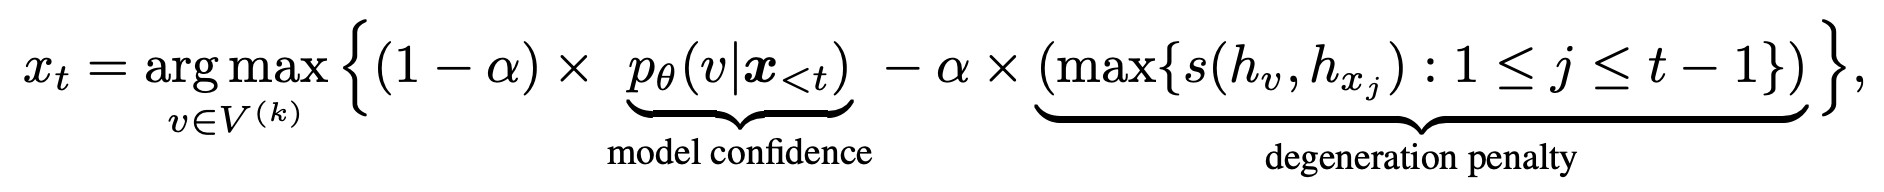

When generating output, contrastive search jointly considers: 

(i) the probability predicted by the language model to maintain the semantic coherence between the generated text and the prefix text; 

(ii) the similarity with respect to the previous context to avoid model degeneration.

In [ ]:
# generate the result with contrastive search
output = model.generate(input_ids, penalty_alpha=0.6, top_k=4, max_length=256)

In [48]:
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))
print("" + 100 * '-')

Output:
----------------------------------------------------------------------------------------------------
In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. 
 Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


According to the study, published in the journal PLOS ONE, the unicorn herd was discovered by a team of scientists led by Dr. Juan Carlos Izpisua Belmonte, a zoologist at the Pontifical Catholic University of Chile. 

"We were surprised to find a herd of unicorn-like creatures in the Andes Mountains," Belmonte said in a statement. "It's an example of what's known as 'ecotourism,' where people travel to remote areas to see animals that are rarely seen in the wild."

The team, which included scientists from the Universidad Nacional Autónoma de México, was conducting research on the mountain range when they came across the herd. 

"We had no idea what